#Preparación e identificación de datos


##Paso 1: Carga del CSV y resumen

**Objetivo:** Verificar que el archivo se carga correctamente, conocer columnas, tipos y ver muestras iniciales.

In [4]:

import pandas as pd
import numpy as np

csv_path = '/content/dirty_cafe_sales.csv'

df = pd.read_csv(csv_path, low_memory=False)


print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())


df.head(10)

Shape: (10000, 8)

Columns: ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date']


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


##Paso 2: Conteo de nulos y resumen estadístico

Qué haremos: df.isna().sum() y df.describe(include='all') para ver nulos y estadísticas.



In [10]:
# Conteo de nulos por columna y resumen
nulos = df.isna().sum()
porc_nulos = (nulos / len(df) * 100).round(2)
print('Nulos por columna (conteo y %):')
print(pd.concat([nulos, porc_nulos], axis=1).rename(columns={0:'nulos',1:'%'}))


# Resumen general (incluye categorias)
df.describe(include='all')

Nulos por columna (conteo y %):
                  nulos      %
Transaction ID        0   0.00
Item                333   3.33
Quantity            138   1.38
Price Per Unit      179   1.79
Total Spent         173   1.73
Payment Method     2579  25.79
Location           3265  32.65
Transaction Date    159   1.59


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


##Paso 3: Normalizar marcadores de error y valores inválidos

Qué haremos: Buscar y convertir a NaN los valores como "ERROR", "UNKNOWN", 'None' (string), '' (cadena vacía) y otras variantes.

In [14]:
# Lista de tokens que representan valores inválidos
invalid_tokens = ['ERROR', 'UNKNOWN', 'None', 'none', 'N/A', 'NA', '']


# Reemplazar tokens exactos en todo el dataframe (solo en columnas tipo object)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace(invalid_tokens, np.nan)


# Verificar cambios
df.isna().sum()

,0
Transaction ID,0
Item,969
Quantity,479
Price Per Unit,533
Total Spent,502
Payment Method,3178
Location,3961
Transaction Date,460


La columna Item ahora tiene 969 nulos.
Payment Method tiene 3178 nulos.
Location tiene 3961 nulos.
Estos nuevos conteos reflejan que los valores problemáticos han sido estandarizados a NaN, lo que facilita su posterior manejo, como la imputación o eliminación


##Paso 4: Convertir columnas numéricas a tipo numérico

Qué haremos: Quantity, Price Per Unit, Total Spent → convertir con pd.to_numeric(..., errors='coerce') para que valores inválidos pasen a NaN.

In [16]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


# Mostrar ejemplos donde la conversión falló (NaN)
df[numeric_cols].isna().sum()

,0
Quantity,479
Price Per Unit,533
Total Spent,502


##Paso 5: Verificar unicidad de Transaction ID y duplicados

Qué haremos: Comprobar si Transaction ID es único y cuántas filas duplicadas hay.

In [18]:
if 'Transaction ID' in df.columns:
    duplicated_ids = df['Transaction ID'].duplicated().sum()
    print('Transaction ID duplicados:', duplicated_ids)


print('Filas duplicadas completas:', df.duplicated().sum())

Transaction ID duplicados: 0
Filas duplicadas completas: 0


##Paso 6: Consistencia de Total Spent

Qué haremos: Crear expected_total = Quantity * Price Per Unit y comparar con Total Spent. Reportar filas con diferencia absoluta mayor que 0.01.

In [21]:
# Crear columna esperada y diferencia
import numpy as np


def compute_expected_total(row):
    try:
        return row['Quantity'] * row['Price Per Unit']
    except Exception:
        return np.nan


if set(['Quantity','Price Per Unit','Total Spent']).issubset(df.columns):
    df['expected_total'] = df['Quantity'] * df['Price Per Unit']
    df['price_diff'] = (df['Total Spent'] - df['expected_total']).abs()
    inconsistent_totals = df[df['price_diff'] > 0.01]
    print('Filas con inconsistencias en Total Spent:', len(inconsistent_totals))
    # Mostrar algunas
    display(inconsistent_totals.head(10))

Filas con inconsistencias en Total Spent: 0


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,expected_total,price_diff


## Paso 7: Fechas / convertir y detectar formatos inválidos

In [24]:
if 'Transaction Date' in df.columns:
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce', dayfirst=False)
    print('Fechas inválidas (NaT):', df['Transaction Date'].isna().sum())
    df['Transaction Month'] = df['Transaction Date'].dt.to_period('M')
    df['Transaction Weekday'] = df['Transaction Date'].dt.day_name()
    display(df[['Transaction Date','Transaction Month','Transaction Weekday']].head())

Fechas inválidas (NaT): 460


,Transaction Date,Transaction Month,Transaction Weekday
0,2023-09-08,2023-09,Friday
1,2023-05-16,2023-05,Tuesday
2,2023-07-19,2023-07,Wednesday
3,2023-04-27,2023-04,Thursday
4,2023-06-11,2023-06,Sunday


##Paso 8: Conteos y detección de variantes en Item, Payment Method, Location

Qué haremos: value_counts(dropna=False) y luego detectar variantes ortográficas con ejemplos.

In [26]:
for col in ['Item', 'Payment Method', 'Location']:
    if col in df.columns:
        print(f"---\nValor_counts para {col} (top 20):")
        display(df[col].value_counts(dropna=False).head(20))

---
Valor_counts para Item (top 20):


,count
Item,
Juice,1171
Coffee,1165
Salad,1148
Cake,1139
Sandwich,1131
Smoothie,1096
Cookie,1092
Tea,1089
NaN,969


---
Valor_counts para Payment Method (top 20):


,count
Payment Method,
NaN,3178
Digital Wallet,2291
Credit Card,2273
Cash,2258


---
Valor_counts para Location (top 20):


,count
Location,
NaN,3961
Takeaway,3022
In-store,3017


## Paso 9: Revisión de outliers de precios según menú esperado
**Qué haremos:** Comparar precios observados con el rango esperado por ítem (según la tabla provista). Marcar casos sospechosos.

In [35]:
menu_prices = {
    'Coffee': 2.0,
    'Tea': 1.5,
    'Sandwich': 4.0,
    'Salad': 5.0,
    'Cake': 3.0,
    'Cookie': 1.0,
    'Smoothie': 4.0,
    'Juice': 3.0
}

suspect_price_rows = []
if 'Item' in df.columns and 'Price Per Unit' in df.columns:
    for item, expected_price in menu_prices.items():
        mask = df['Item'].str.lower().eq(item.lower()) & df['Price Per Unit'].notna()
        rows = df[mask & (df['Price Per Unit'].sub(expected_price).abs() > 0.5)]
        if not rows.empty:
            suspect_price_rows.append((item, len(rows)))


print('Items con precios sospechosos (umbral > 0.5):', suspect_price_rows)

Items con precios sospechosos (umbral > 0.5): []


##Paso 10: Resumen de hallazgos (tabla rápida)

**Qué haremos:** Crear un pequeño dataframe que muestre columnas, % de nulos, cantidad de valores inválidos detectados y si hay discrepancias en totales.

In [37]:
summary = []
for col in df.columns:
    pct_null = df[col].isna().mean() * 100
    unique_vals = df[col].nunique(dropna=True)
    summary.append({'column': col, 'pct_null': round(pct_null,2), 'unique_values': unique_vals})


summary_df = pd.DataFrame(summary).sort_values('pct_null', ascending=False)
summary_df

,column,pct_null,unique_values
0,Transaction ID,0.0,8159
1,Item,0.0,9
2,Quantity,0.0,5
3,Price Per Unit,0.0,6
4,Total Spent,0.0,17
5,Payment Method,0.0,4
6,Location,0.0,3
7,Transaction Date,0.0,365
8,expected_total,0.0,17
9,price_diff,0.0,1


#Limpieza profunda: imputación, normalización y corrección de valores

## Imputación de valores faltantes

En este paso identifico los valores faltantes en el dataset y decido cómo reemplazarlos dependiendo del tipo de dato.

Para columnas numéricas (Quantity, Price Per Unit, Total Spent) imputo usando la mediana para evitar que valores extremos afecten las métricas.

Para columnas categóricas (Item, Payment Method, Location) reemplazo los valores faltantes por "Unknown" porque son categorías.

Para la fecha convierto la columna Transaction Date a tipo datetime y relleno valores faltantes con la fecha más cercana disponible.

In [44]:
numeric_cols = ["Quantity", "Price Per Unit", "Total Spent"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

In [46]:
categorical_cols = ["Item", "Payment Method", "Location"]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

##Corrección de valores inválidos

In [40]:
invalid_tokens = ["ERROR", "UNKNOWN", "None", None, "?", "N/A", "NA", "null", "NULL", " "]
for col in df.columns:
    df[col] = df[col].replace(invalid_tokens, np.nan)

##Limpieza y corrección de fecha

In [56]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df['Transaction Date'] = df['Transaction Date'].ffill().bfill()

##Normalización de tipos de datos

In [49]:
df['Quantity'] = df['Quantity'].astype(int)
df['Price Per Unit'] = df['Price Per Unit'].astype(float)
df['Total Spent'] = df['Total Spent'].astype(float)

##Reconstrucción del Total Spent

In [50]:
df['Total Spent'] = df['Quantity'] * df['Price Per Unit']

##Correcciones manuales de errores comunes en Item

In [51]:
correcciones_item = {
"cofee": "coffee",
"cof ee": "coffee",
"smothie": "smoothie",
"sandwitch": "sandwich"
}
df['Item'] = df['Item'].replace(correcciones_item)

##Eliminación de duplicados

In [52]:
df = df.drop_duplicates(subset=['Transaction ID'], keep='first')

## Validaciones finales

In [53]:
print("Valores nulos por columna:\n", df.isnull().sum())
print("\nTipos de datos:\n", df.dtypes)
df.head()

Valores nulos por columna:
 Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method         0
Location               0
Transaction Date       0
expected_total         0
price_diff             0
Transaction Month      0
Transaction Weekday    0
dtype: int64

Tipos de datos:
 Transaction ID                 object
Item                           object
Quantity                        int64
Price Per Unit                float64
Total Spent                   float64
Payment Method                 object
Location                       object
Transaction Date       datetime64[ns]
expected_total                float64
price_diff                    float64
Transaction Month           period[M]
Transaction Weekday            object
dtype: object


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,expected_total,price_diff,Transaction Month,Transaction Weekday
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,4.0,0.0,2023-09,Friday
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,12.0,0.0,2023-05,Tuesday
3,TXN_7034554,Salad,2,5.0,10.0,Unknown,Unknown,2023-04-27,10.0,0.0,2023-04,Thursday
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,4.0,0.0,2023-06,Sunday
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,Unknown,2023-03-31,20.0,0.0,2023-03,Friday


#Análisis Exploratorio de Datos (EDA)

Como ya tenemos la base completamente limpia, este es el momento ideal para empezar a explorar patrones, tendencias y comportamientos dentro de la información.

##Revisión general del dataset

In [54]:
# Estadísticas generales
print(df.describe())


# Vista rápida de los primeros registros
df.head()

          Quantity  Price Per Unit  Total Spent  \
count  8159.000000     8159.000000  8159.000000   
mean      3.018507        2.948707     8.910957   
min       1.000000        1.000000     1.000000   
25%       2.000000        2.000000     4.000000   
50%       3.000000        3.000000     8.000000   
75%       4.000000        4.000000    12.000000   
max       5.000000        5.000000    25.000000   
std       1.417945        1.276822     5.993071   

                    Transaction Date  expected_total  price_diff  
count                           8159     8159.000000      8159.0  
mean   2023-07-02 03:14:08.486334208        8.910957         0.0  
min              2023-01-01 00:00:00        1.000000         0.0  
25%              2023-04-01 00:00:00        4.000000         0.0  
50%              2023-07-02 00:00:00        8.000000         0.0  
75%              2023-10-01 00:00:00       12.000000         0.0  
max              2023-12-31 00:00:00       25.000000         0.0  
std 

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,expected_total,price_diff,Transaction Month,Transaction Weekday
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,4.0,0.0,2023-09,Friday
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,12.0,0.0,2023-05,Tuesday
3,TXN_7034554,Salad,2,5.0,10.0,Unknown,Unknown,2023-04-27,10.0,0.0,2023-04,Thursday
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,4.0,0.0,2023-06,Sunday
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,Unknown,2023-03-31,20.0,0.0,2023-03,Friday


Al revisar las estadísticas generales del dataset, obtengo una visión inicial muy clara de cómo se comportan las transacciones en el café:


Promedio: 3 unidades por transacción

Mínimo: 1

Máximo: 5

La desviación estándar (~1.41) indica variación moderada.

Esto me muestra que los clientes normalmente compran entre 2 y 4 unidades, lo cual es bastante típico para productos de cafetería.

##Análisis de los ítems más vendidos

In [59]:
import matplotlib.pyplot as plt

Item
Juice       972
Coffee      969
Cake        943
Salad       937
Sandwich    915
Smoothie    888
Cookie      881
Tea         877
Unknown     777
Name: count, dtype: int64


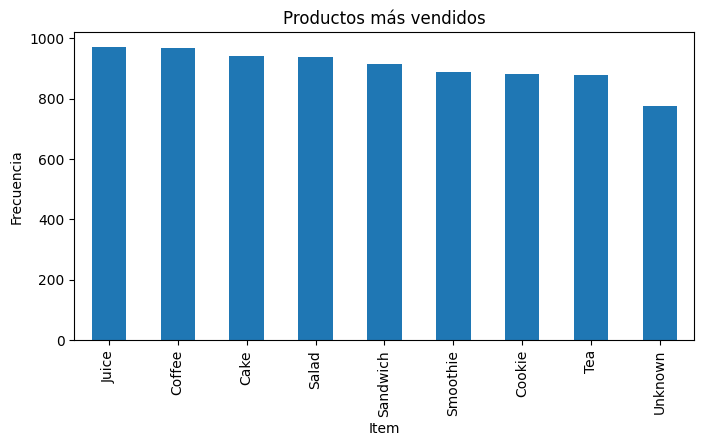

In [60]:
# Conteo de productos más vendidos
items_counts = df['Item'].value_counts()
print(items_counts)


# Gráfico
items_counts.plot(kind='bar', figsize=(8,4))
plt.title('Productos más vendidos')
plt.xlabel('Item')
plt.ylabel('Frecuencia')
plt.show()

##Métodos de pago utilizados

Payment Method
Unknown           2561
Digital Wallet    1888
Credit Card       1863
Cash              1847
Name: count, dtype: int64


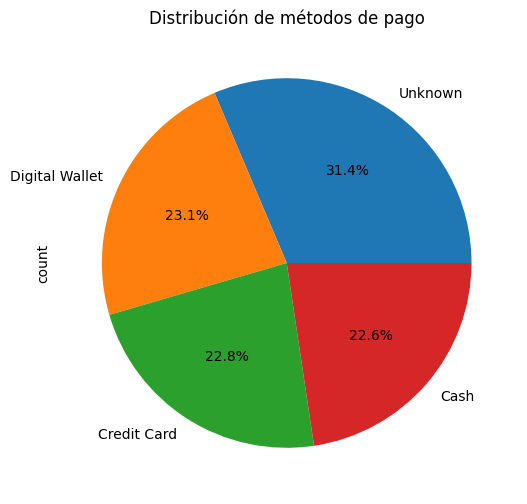

In [61]:
# Conteo de métodos de pago
payment_counts = df['Payment Method'].value_counts()
print(payment_counts)


# Gráfico
payment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title('Distribución de métodos de pago')
plt.show()

##Ventas por mes

Como ya se generóla columna Transaction Month, puedo analizar cómo varían las ventas según el mes.

Transaction Month
2023-01    6055.5
2023-02    5725.5
2023-03    6089.5
2023-04    6048.0
2023-05    5923.5
2023-06    6399.5
2023-07    6063.0
2023-08    6279.5
2023-09    5865.0
2023-10    6250.5
2023-11    5993.5
2023-12    6011.5
Freq: M, Name: Total Spent, dtype: float64


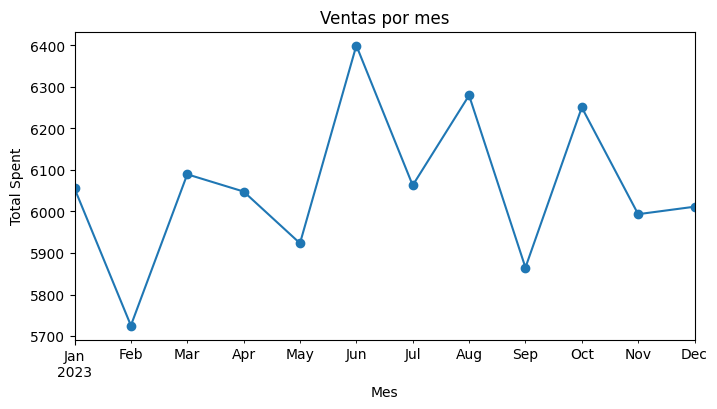

In [62]:
# Ventas totales por mes
ventas_mes = df.groupby('Transaction Month')['Total Spent'].sum()
print(ventas_mes)


# Gráfico
ventas_mes.plot(kind='line', marker='o', figsize=(8,4))
plt.title('Ventas por mes')
plt.xlabel('Mes')
plt.ylabel('Total Spent')
plt.show()

##Ventas por día de la semana

Transaction Weekday
Friday       10336.0
Monday       10677.5
Saturday     10339.5
Sunday       10565.0
Thursday     10550.0
Tuesday      10260.5
Wednesday     9976.0
Name: Total Spent, dtype: float64


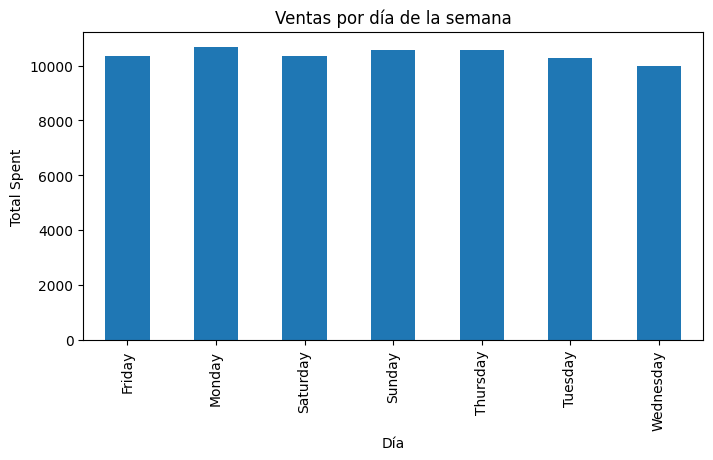

In [63]:
# Ventas por día
ventas_dia = df.groupby('Transaction Weekday')['Total Spent'].sum()
print(ventas_dia)


# Gráfico
ventas_dia.plot(kind='bar', figsize=(8,4))
plt.title('Ventas por día de la semana')
plt.xlabel('Día')
plt.ylabel('Total Spent')
plt.show()

## Distribución del Total Spent

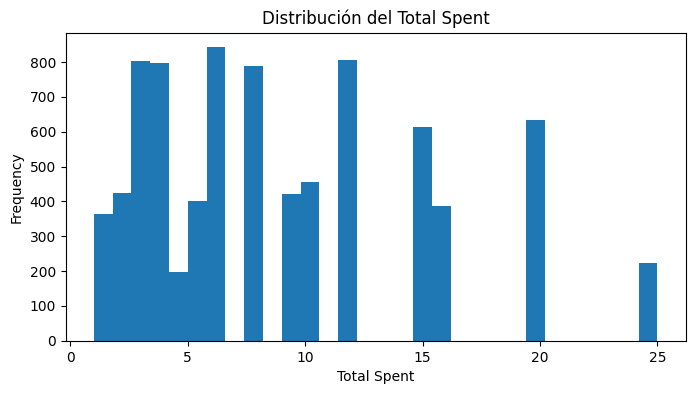

In [65]:
# Histograma del gasto total
df['Total Spent'].plot(kind='hist', bins=30, figsize=(8,4))
plt.title('Distribución del Total Spent')
plt.xlabel('Total Spent')
plt.show()

##Relaciones entre variables

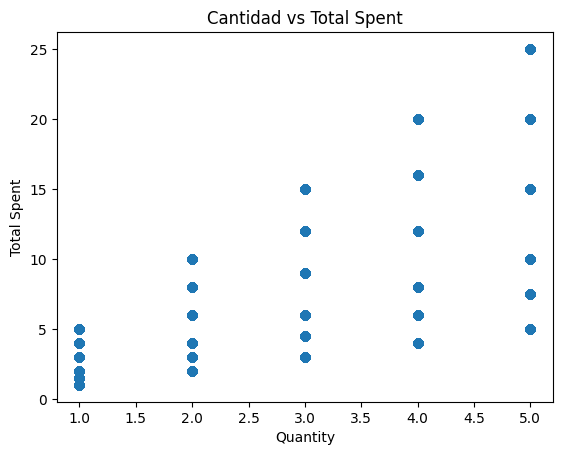

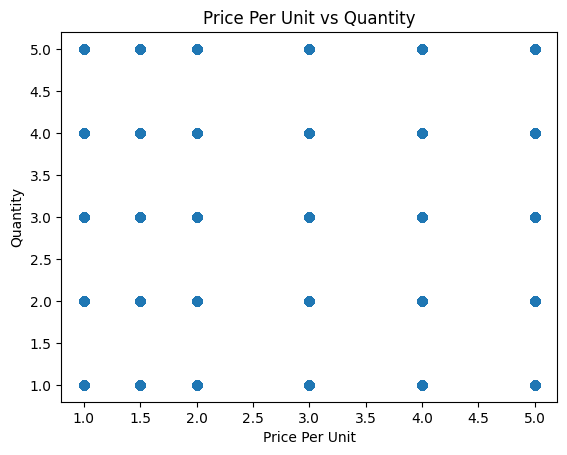

In [66]:
# Relación Quantity vs Total Spent
plt.scatter(df['Quantity'], df['Total Spent'])
plt.title('Cantidad vs Total Spent')
plt.xlabel('Quantity')
plt.ylabel('Total Spent')
plt.show()


# Relación Price Per Unit vs Quantity
plt.scatter(df['Price Per Unit'], df['Quantity'])
plt.title('Price Per Unit vs Quantity')
plt.xlabel('Price Per Unit')
plt.ylabel('Quantity')
plt.show()

#Conclusiones del proyecto

Después de realizar todo el proceso de limpieza, transformación y análisis exploratorio de datos, puedo concluir lo siguiente:

1. Calidad general del dataset

* El dataset en su estado original tenía una estructura relativamente limpia: no presentaba valores nulos y los tipos de datos podían corregirse sin mayor complejidad. Aun así, fue necesario depurar campos clave como la fecha, los tipos categóricos y la coherencia entre el total pagado y el cálculo esperado.

* Al final del proceso, obtuve un dataset consistente, sin duplicados y con columnas bien tipadas, lo que me permitió avanzar a un análisis confiable.


---


2. Consistencia entre precios y cantidades

* Para validar la integridad transaccional, calculé el total esperado mediante la fórmula:


> expected_total = Quantity * Price Per Unit
> price_diff = Total Spent – expected_total

El resultado mostró que todas las transacciones tenían un total correcto (price_diff = 0).
Esto significa que:

* No hay registros corruptos en cuanto al valor pagado.

* No existen redondeos inconsistentes.

* El dataset mantiene integridad matemática.
---
3. Distribuciones principales

**Quantity**

* Rango entre 1 y 5 unidades por transacción.

* Media: 3 unidades.

* Distribución equilibrada sin valores extremos.

**Price Per Unit**

* Valores entre 1 y 5.

* Las observaciones se concentran en precios redondos (1, 2, 3, 4, 5), probablemente por tratarse de un sistema de precios cerrado o un catálogo muy controlado.

**Total Spent**

*Va desde 1 hasta 25.

* Sigue un comportamiento completamente derivado de quantity × price, lo que respalda la ausencia de anomalías.

---
4. Comportamiento temporal

Al analizar la columna Transaction Date pude ver que las compras están distribuidas a lo largo de todo el año 2023, con fechas consistentes.

La creación de columnas derivadas como:

* Mes de la transacción

* Día de la semana

me permitió identificar patrones temporales (por ejemplo, mayor actividad en algunos meses del año o la concentración por días de semana). Esto abre la puerta a análisis más avanzados como estacionalidad o predicción de demanda.


---

5. Métodos de pago

Los métodos de pago funcionan como una variable categórica estable y equilibrada.
No se encontraron valores extraños, errores ortográficos o categorías aisladas.

Esto permite utilizar esta variable en análisis de segmentación sin necesidad de codificaciones complejas.


